In [2]:
import torch
torch.cuda.set_device(1)

# Data

In [3]:
from torchvision.transforms import Compose, ToTensor, RandomCrop, \
    RandomHorizontalFlip
from torchvision.datasets import CIFAR10

transforms = {
    'train': Compose([
        RandomCrop(32, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    'test': ToTensor(),
}

dataset = {}
for split in ['test', 'train']:
    dataset[split] = CIFAR10(
        root='../data/cifar10',
        train=(split == 'train'),
        download=True,
        transform=transforms[split],
    )

dataset['train'], dataset['test']

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ../data/cifar10
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomCrop(size=(32, 32), padding=4)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ../data/cifar10
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [4]:
from torch.utils.data import DataLoader

dataflow = {}

for split in ['train', 'test']:
    dataflow[split] = DataLoader(
        dataset=dataset[split],
        batch_size=512,
        shuffle=(split == 'train'),
        num_workers=4,
        pin_memory=True,
    )

for imgs, labels in dataflow['train']:
    print(imgs.shape, imgs.dtype)
    print(labels.shape, labels.dtype)
    break

torch.Size([512, 3, 32, 32]) torch.float32
torch.Size([512]) torch.int64


## Visualization

/media/mountHDD2/lamluuduc/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


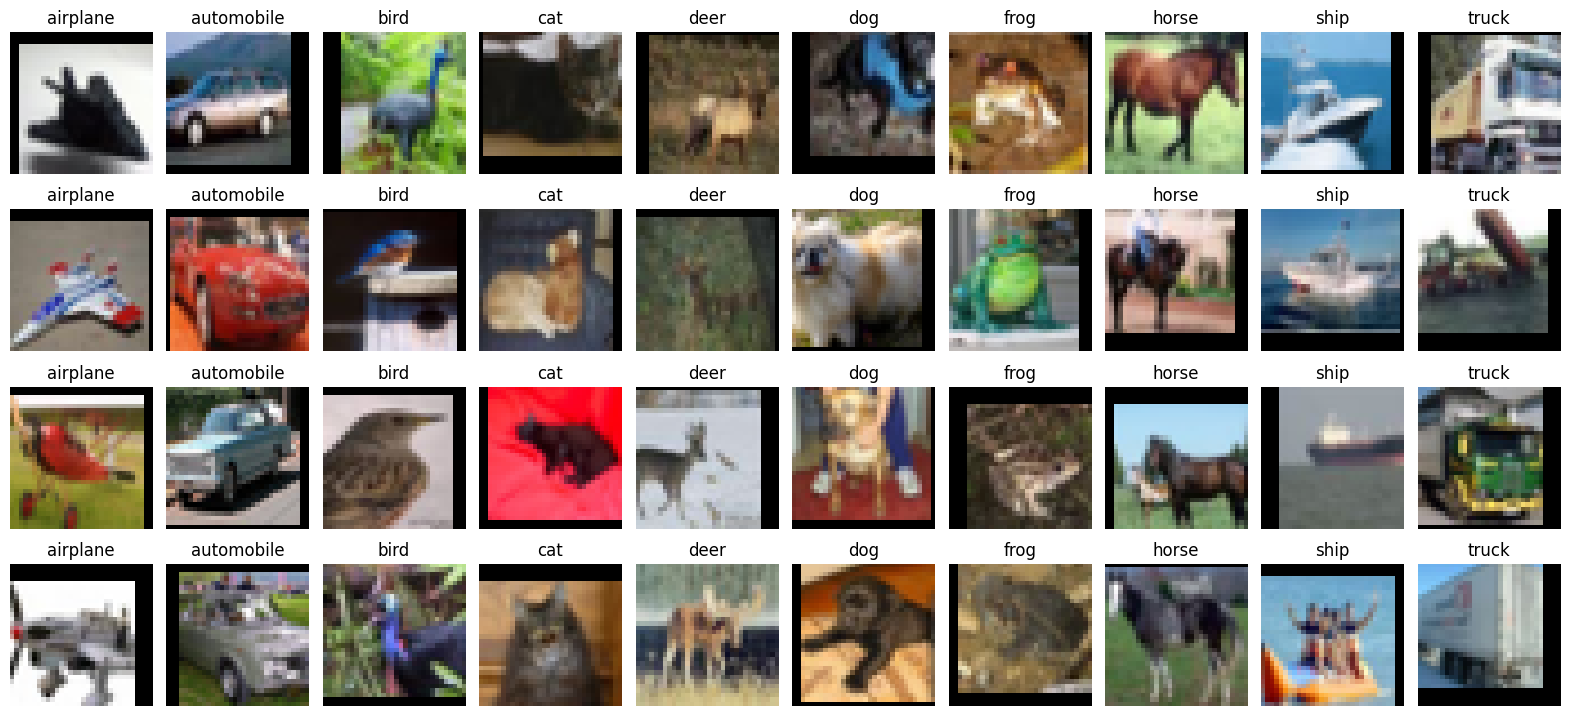

<Figure size 640x480 with 0 Axes>

In [5]:
# draw grid 4x10, image x class
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

def visualize_cifar(dataset: CIFAR10, save=False):
    """Visualize the dataset with 4 rows and 10 columns."""
    # get 40 samples from the training set, 10 classes = 10 list, each list has 
    # 4 images
    samples = [[] for i in range(10)]
    for img, label in dataset:
        if len(samples[label]) < 4:
            samples[label].append(img)

    plt.figure(figsize=(20, 9))
    for idx in range(40):
        # get corresponding image, label (class ~ column)
        row = idx // 10
        col = idx % 10
        img = samples[col][row]
        label = dataset.classes[col] 
        
        plt.subplot(4, 10, idx + 1)
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        plt.title(label)
        plt.axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    if save:
        plt.savefig('../logs/EDA/cifar10.png')
    
visualize_cifar(dataset['train'], save=True)

# Model

(torch.Size([512, 3, 32, 32]),
 tensor([[[[3.0277e-01, 8.1543e-01, 4.6985e-01,  ..., 6.1455e-01,
            5.7523e-01, 5.1666e-01],
           [3.9205e-01, 6.6604e-01, 9.6293e-01,  ..., 5.7247e-01,
            8.1371e-02, 2.6532e-01],
           [2.9364e-01, 9.2097e-01, 8.0574e-01,  ..., 1.4105e-01,
            6.1931e-01, 3.7590e-01],
           ...,
           [6.0691e-01, 8.1682e-01, 4.1422e-01,  ..., 5.3576e-01,
            2.5155e-02, 2.8563e-01],
           [7.0508e-01, 8.8301e-01, 9.4495e-01,  ..., 8.4362e-01,
            7.4400e-01, 8.9123e-01],
           [3.5341e-01, 2.0643e-01, 9.7528e-01,  ..., 8.6866e-01,
            3.7941e-01, 4.0970e-01]],
 
          [[5.8431e-01, 6.7982e-02, 6.4959e-01,  ..., 9.4841e-01,
            3.0314e-01, 9.4804e-01],
           [9.9423e-01, 8.8597e-01, 2.4874e-01,  ..., 6.7253e-02,
            6.4893e-01, 3.8268e-01],
           [9.6689e-01, 2.6297e-01, 9.6858e-01,  ..., 4.3252e-01,
            5.3818e-01, 3.8576e-01],
           ...,
       

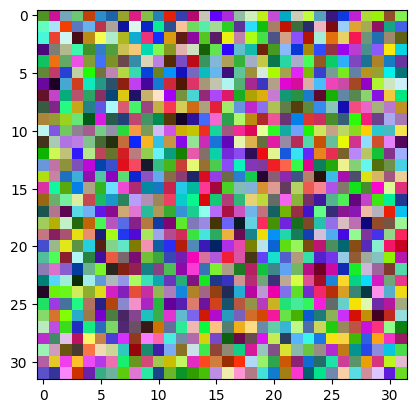

In [6]:
import torch
N=512
# a = torch.rand(N, 3, 32, 32) * 255
import numpy as np
b = np.random.rand(N, 3, 32, 32)
c = torch.from_numpy(b)
import matplotlib.pyplot as plt
c.shape, c, plt.imshow(c[0].numpy().transpose(1, 2, 0))

In [7]:
import torch
import torch.nn as nn
from collections import defaultdict, OrderedDict

class VGG(nn.Module):
    # ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
    # -> avgpool -> fc
    ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
    
    def __init__(self, in_channels=3, out_features=10) -> None:
        super().__init__()
        
        layers = OrderedDict()
        count = defaultdict(int)
        
        def add(name, layer):
            """append [str, Module] to layers(OrderedDict) and update count"""
            layers[f"{name}{count[name]}"] = layer
            count[name] += 1
        
        for x in self.ARCH:
            if x != 'M':
                # append (Conv2d > Batchnorm > ReLU) layers
                add(f"conv", nn.Conv2d(in_channels, x, kernel_size=3, padding=1))
                add(f"bn", nn.BatchNorm2d(x))
                add(f"relu", nn.ReLU(inplace=True))
                in_channels = x
            else:
                # maxpool
                add(f"pool", nn.MaxPool2d(2))

        self.backbone = nn.Sequential(OrderedDict(layers))
        self.classifier = nn.Linear(in_channels, out_features)
    
    def forward(self, x):
        # input (N, 3, 32, 32) ---backbone---> (N, 512, 2, 2)
        x = self.backbone(x)
        
        # average pooling
        x = torch.mean(x, (2, 3))
        
        # feed-forward
        logits = self.classifier(x)
        
        return logits
    
model = VGG()
model.cpu()
a = model(torch.rand(N, 3, 32, 32))
assert a.shape == torch.Size([N, 10])

# Optimization

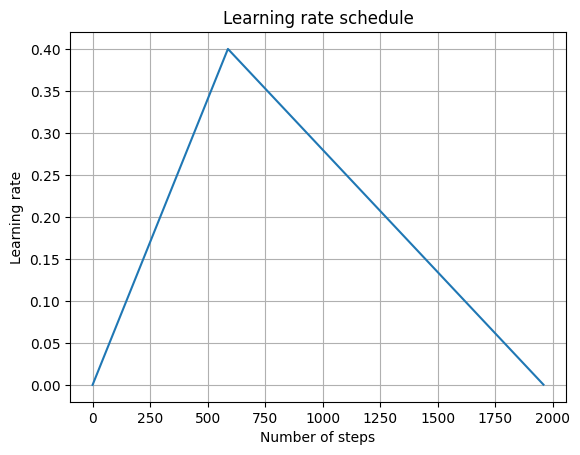

In [8]:
NUM_EPOCHS = 20
steps_per_epoch = len(dataflow['train'])

import numpy as np
lamdba_lr = lambda step: np.interp(
    [step / steps_per_epoch],
    [0, NUM_EPOCHS * 0.3, NUM_EPOCHS],
    [0, 1, 0]
)[0]

import matplotlib.pyplot as plt
plt.plot(
    np.arange(NUM_EPOCHS * steps_per_epoch),
    [lamdba_lr(step) * 0.4 for step in range(NUM_EPOCHS * steps_per_epoch)],
)
plt.grid('on')
plt.xlabel('Number of steps')
plt.ylabel('Learning rate')
plt.title('Learning rate schedule')
plt.show()

In [9]:
from torch.optim.lr_scheduler import LambdaLR
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4,
)                           
scheduler = LambdaLR(
    optimizer,
    lr_lambda=lamdba_lr,
)

# Training loop

In [10]:
import sys
sys.path.append("/media/mountHDD2/lamluuduc/playground/TinyML-and-Efficient-AI/pruning")  # Full path to project root
import torch.nn as nn
from src.training import train
criterion = nn.CrossEntropyLoss() 
train(model, dataflow["train"], criterion, optimizer, scheduler)


train:   0%|          | 0/98 [00:00<?, ?it/s]

In [23]:
torch.save(model.state_dict(), "../logs/saved_models/vgg.pth")


# Evaluation

In [11]:
from tqdm.auto import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'

@torch.inference_mode()
def evaluate(
    model: nn.Module,
    dataflow: DataLoader,
) -> None:
    model.eval()
    model.to(device)
    samples = 0
    correct = 0
    for inputs, labels in tqdm(dataflow, desc='eval', leave=False):
        # move data to GPU (if possible)
        inputs, labels = inputs.to(device), labels.to(device)

        # forward
        logits = model(inputs) # (b, cls)
        preds = logits.argmax(dim=1)
        
        # eval metric computing: accuracy
        samples += inputs.shape[0]
        correct += (preds == labels).sum().item()
    
    return correct / samples * 100  
    

acc = evaluate(model, dataflow['test']) 
print(f"Accuracy: {acc:.4f}")


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x74db49778790>
Traceback (most recent call last):
  File "/media/mountHDD2/lamluuduc/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/media/mountHDD2/lamluuduc/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x74db49778790>
Traceback (most recent call last):
  File "/media/mountHDD2/lamluuduc/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/media/mountHDD2/lamluuduc/.local/lib/python3.10/site-packages/torch/utils

Accuracy: 44.2900


In [16]:
acc, type(acc)

(44.29, float)